# 🔧 NYC Taxi Trip Duration - Feature Engineering & Preprocessing

### Notebook Overview

This notebook implements **data preprocessing** and **feature engineering** following Big Data best practices:

1. **Data Loading with Dask** - Scalable processing
2. **Data Cleaning** - Handling missing values, outliers
3. **Feature Engineering** - Creating predictive features
4. **Data Transformation** - Encoding and scaling
5. **Train-Test Split** - Preparing data for modeling
6. **Feature Selection** - Identifying important features
7. **Data Export** - Saving processed data in Parquet format

## 1. Configuration & Imports

In [2]:
# Standard Libraries
import os
import sys
import warnings
from pathlib import Path

# Big Data Processing
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Project Paths
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
VISUALIZATIONS = PROJECT_ROOT / 'visualizations'

# Create directories if they don't exist
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("🔧 Feature Engineering & Preprocessing")
print("=" * 60)
print(f"\n📁 Project Root: {PROJECT_ROOT}")
print(f"📊 Raw Data: {DATA_RAW}")
print(f"💾 Processed Data: {DATA_PROCESSED}")
print("\n✅ All libraries imported successfully!")

🔧 Feature Engineering & Preprocessing

📁 Project Root: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata
📊 Raw Data: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata\data\raw
💾 Processed Data: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata\data\processed

✅ All libraries imported successfully!


## 2. Data Loading with Big Data (Dask)

In [3]:
# Load data using Dask
print("📥 Loading data with Dask...")
print("-" * 50)

train_path = DATA_RAW / 'train.csv'
test_path = DATA_RAW / 'test.csv'

if train_path.exists():
    # Dask for Big Data scalability
    ddf = dd.read_csv(train_path, parse_dates=['pickup_datetime'])
    df = ddf.compute()
    
    ddf_test = dd.read_csv(test_path, parse_dates=['pickup_datetime'])
    df_test = ddf_test.compute()
    
    print(f"✅ Training data: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"✅ Test data: {df_test.shape[0]:,} rows × {df_test.shape[1]} columns")
else:
    # Create demo data if files don't exist
    print("⚠️ Creating synthetic demo data...")
    np.random.seed(42)
    n_samples = 10000
    
    df = pd.DataFrame({
        'id': [f'id_{i}' for i in range(n_samples)],
        'vendor_id': np.random.choice([1, 2], n_samples),
        'pickup_datetime': pd.date_range('2016-01-01', periods=n_samples, freq='5min'),
        'dropoff_datetime': pd.date_range('2016-01-01', periods=n_samples, freq='5min') + pd.Timedelta(minutes=15),
        'passenger_count': np.random.choice(range(1, 7), n_samples),
        'pickup_longitude': np.random.uniform(-74.05, -73.75, n_samples),
        'pickup_latitude': np.random.uniform(40.63, 40.85, n_samples),
        'dropoff_longitude': np.random.uniform(-74.05, -73.75, n_samples),
        'dropoff_latitude': np.random.uniform(40.63, 40.85, n_samples),
        'store_and_fwd_flag': np.random.choice(['N', 'Y'], n_samples, p=[0.98, 0.02]),
        'trip_duration': np.random.lognormal(6, 0.8, n_samples).astype(int)
    })
    df_test = df.drop(columns=['trip_duration', 'dropoff_datetime']).head(2000)
    print(f"✅ Demo data created: {df.shape}")

print(f"\n💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📥 Loading data with Dask...
--------------------------------------------------
✅ Training data: 1,458,644 rows × 11 columns
✅ Test data: 625,134 rows × 9 columns

💾 Memory usage: 173.88 MB


## 3. Data Cleaning

### Cleaning Strategy
1. **Remove duplicates** - Ensure data integrity
2. **Handle missing values** - Impute or remove
3. **Filter geographic outliers** - Keep only valid NYC coordinates
4. **Cap extreme trip durations** - Remove unrealistic values
5. **Validate passenger counts** - Check for anomalies

In [4]:
# Data Cleaning Pipeline
print("🧹 DATA CLEANING PIPELINE")
print("=" * 60)

initial_rows = len(df)
print(f"\n📊 Initial records: {initial_rows:,}")

# Step 1: Remove duplicates
df = df.drop_duplicates()
after_dedup = len(df)
print(f"\n1️⃣ After removing duplicates: {after_dedup:,} (removed {initial_rows - after_dedup:,})")

# Step 2: Handle missing values
null_before = df.isnull().sum().sum()
df = df.dropna()
null_after = df.isnull().sum().sum()
after_null = len(df)
print(f"2️⃣ After handling nulls: {after_null:,} (removed {after_dedup - after_null:,})")

# Step 3: Filter geographic outliers (NYC bounds)
NYC_BOUNDS = {
    'min_lat': 40.5774, 'max_lat': 40.9176,
    'min_lon': -74.15, 'max_lon': -73.7004
}

df = df[
    (df['pickup_latitude'].between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat'])) &
    (df['pickup_longitude'].between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon'])) &
    (df['dropoff_latitude'].between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat'])) &
    (df['dropoff_longitude'].between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon']))
]
after_geo = len(df)
print(f"3️⃣ After geographic filtering: {after_geo:,} (removed {after_null - after_geo:,})")

# Step 4: Cap extreme trip durations (1 minute to 3 hours)
MIN_DURATION = 60      # 1 minute
MAX_DURATION = 10800   # 3 hours

df = df[(df['trip_duration'] >= MIN_DURATION) & (df['trip_duration'] <= MAX_DURATION)]
after_duration = len(df)
print(f"4️⃣ After duration filtering: {after_duration:,} (removed {after_geo - after_duration:,})")

# Step 5: Validate passenger count (1-6 passengers)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]
final_rows = len(df)
print(f"5️⃣ After passenger validation: {final_rows:,} (removed {after_duration - final_rows:,})")

# Summary
print(f"\n" + "=" * 60)
print(f"📋 CLEANING SUMMARY")
print(f"   • Initial records: {initial_rows:,}")
print(f"   • Final records: {final_rows:,}")
print(f"   • Total removed: {initial_rows - final_rows:,} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)")
print(f"   • Data retained: {final_rows/initial_rows*100:.2f}%")

🧹 DATA CLEANING PIPELINE

📊 Initial records: 1,458,644

1️⃣ After removing duplicates: 1,458,644 (removed 0)
2️⃣ After handling nulls: 1,458,644 (removed 0)
3️⃣ After geographic filtering: 1,454,166 (removed 4,478)
4️⃣ After duration filtering: 1,443,758 (removed 10,408)
5️⃣ After passenger validation: 1,443,740 (removed 18)

📋 CLEANING SUMMARY
   • Initial records: 1,458,644
   • Final records: 1,443,740
   • Total removed: 14,904 (1.02%)
   • Data retained: 98.98%


## 4. Feature Engineering

### New Features Created
1. **Temporal Features** - Hour, day, month, weekday, rush hour indicator
2. **Geographic Features** - Haversine distance, Manhattan distance
3. **Speed Estimations** - Based on distance and duration
4. **Cyclical Encoding** - Sin/cos transformation for time features

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points in kilometers.
    
    The Haversine formula calculates the great-circle distance between
    two points on a sphere given their longitudes and latitudes.
    """
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c


def manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Calculate Manhattan (taxicab) distance in kilometers.
    More realistic for city grid layouts like NYC.
    """
    # Approximate degrees to km conversion at NYC latitude
    lat_km = 111.32  # km per degree latitude
    lon_km = 85.39   # km per degree longitude at 40°N
    
    return np.abs(lat2 - lat1) * lat_km + np.abs(lon2 - lon1) * lon_km


print("🔧 FEATURE ENGINEERING")
print("=" * 60)

🔧 FEATURE ENGINEERING


In [6]:
# Create all features
def create_features(df):
    """
    Create all engineered features for the dataset.
    """
    df = df.copy()
    
    # Ensure datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    
    # ======== TEMPORAL FEATURES ========
    print("📅 Creating temporal features...")
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['weekofyear'] = df['pickup_datetime'].dt.isocalendar().week.astype(int)
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Rush hour indicator (7-9 AM and 5-7 PM on weekdays)
    df['is_rush_hour'] = (
        (~df['is_weekend'].astype(bool)) & 
        ((df['hour'].between(7, 9)) | (df['hour'].between(17, 19)))
    ).astype(int)
    
    # Night time indicator
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int)
    
    # Cyclical encoding for hour (preserves circular nature)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Cyclical encoding for day of week
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # ======== GEOGRAPHIC FEATURES ========
    print("🗺️ Creating geographic features...")
    
    # Haversine distance (great-circle distance)
    df['haversine_distance'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    
    # Manhattan distance
    df['manhattan_distance'] = manhattan_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    
    # Direction (bearing) from pickup to dropoff
    df['direction'] = np.arctan2(
        df['dropoff_longitude'] - df['pickup_longitude'],
        df['dropoff_latitude'] - df['pickup_latitude']
    )
    
    # Center point coordinates
    df['center_latitude'] = (df['pickup_latitude'] + df['dropoff_latitude']) / 2
    df['center_longitude'] = (df['pickup_longitude'] + df['dropoff_longitude']) / 2
    
    # ======== AIRPORT INDICATORS ========
    print("✈️ Creating airport indicators...")
    
    # JFK Airport coordinates
    JFK_LAT, JFK_LON = 40.6413, -73.7781
    # LaGuardia Airport coordinates  
    LGA_LAT, LGA_LON = 40.7769, -73.8740
    
    # Distance to airports
    df['dist_to_jfk_pickup'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'], JFK_LAT, JFK_LON
    )
    df['dist_to_lga_pickup'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'], LGA_LAT, LGA_LON
    )
    
    # Airport trip indicators (within 2km of airport)
    df['is_jfk_trip'] = ((df['dist_to_jfk_pickup'] < 2) | 
                         (haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], 
                                            JFK_LAT, JFK_LON) < 2)).astype(int)
    df['is_lga_trip'] = ((df['dist_to_lga_pickup'] < 2) | 
                         (haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], 
                                            LGA_LAT, LGA_LON) < 2)).astype(int)
    
    # ======== ENCODE CATEGORICAL ========
    print("🏷️ Encoding categorical features...")
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
    
    return df

# Apply feature engineering
df = create_features(df)
print(f"\n✅ Feature engineering complete!")
print(f"📊 Final dataset shape: {df.shape}")

📅 Creating temporal features...
🗺️ Creating geographic features...
✈️ Creating airport indicators...
🏷️ Encoding categorical features...

✅ Feature engineering complete!
📊 Final dataset shape: (1443740, 32)


In [7]:
# Display new features
new_features = ['hour', 'dayofweek', 'is_weekend', 'is_rush_hour', 'is_night',
                'hour_sin', 'hour_cos', 'haversine_distance', 'manhattan_distance',
                'direction', 'is_jfk_trip', 'is_lga_trip']

print("📋 NEW FEATURES CREATED")
print("=" * 60)
print(df[new_features].describe().T)

📋 NEW FEATURES CREATED
                        count       mean       std       min       25%  \
hour                1443740.0  13.615661  6.397813  0.000000  9.000000   
dayofweek           1443740.0   3.049403  1.953719  0.000000  1.000000   
is_weekend          1443740.0   0.285167  0.451494  0.000000  0.000000   
is_rush_hour        1443740.0   0.239071  0.426517  0.000000  0.000000   
is_night            1443740.0   0.220200  0.414382  0.000000  0.000000   
hour_sin            1443740.0  -0.202442  0.672614 -1.000000 -0.866025   
hour_cos            1443740.0  -0.084387  0.706744 -1.000000 -0.707107   
haversine_distance  1443740.0   3.406676  3.813969  0.000000  1.242683   
manhattan_distance  1443740.0   4.433914  5.121463  0.000000  1.595735   
direction           1443740.0  -0.232249  1.789030 -3.141425 -2.069572   
is_jfk_trip         1443740.0   0.028270  0.165742  0.000000  0.000000   
is_lga_trip         1443740.0   0.037695  0.190458  0.000000  0.000000   

              

## 5. Target Variable Transformation

The target variable (trip_duration) has a right-skewed distribution. We apply a **log transformation** to normalize it, which improves model performance.

🎯 TARGET VARIABLE TRANSFORMATION


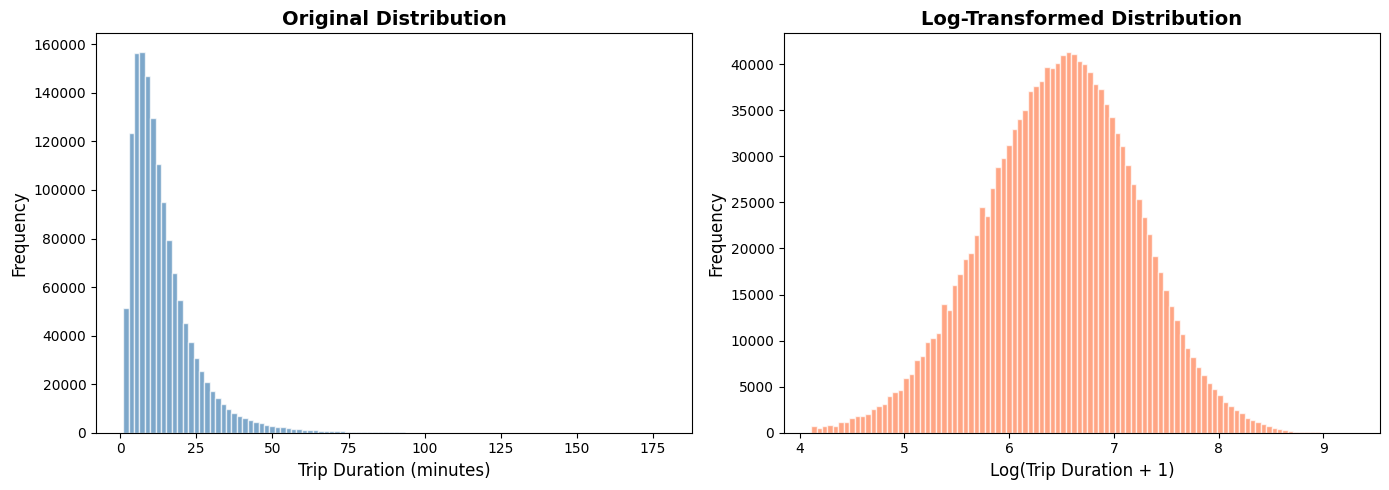


📊 Original Statistics:
   Mean: 837.33 seconds
   Std: 651.29
   Skewness: 2.31

📊 Log-Transformed Statistics:
   Mean: 6.48
   Std: 0.73
   Skewness: -0.14


In [8]:
# Log transformation of target variable
print("🎯 TARGET VARIABLE TRANSFORMATION")
print("=" * 60)

# Apply log1p transformation (log(1 + x) to handle zeros)
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# Visualize transformation effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df['trip_duration'] / 60, bins=100, color='steelblue', alpha=0.7, edgecolor='white')
axes[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Original Distribution', fontsize=14, fontweight='bold')

# Log-transformed distribution
axes[1].hist(df['log_trip_duration'], bins=100, color='coral', alpha=0.7, edgecolor='white')
axes[1].set_xlabel('Log(Trip Duration + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(VISUALIZATIONS / 'target_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Original Statistics:")
print(f"   Mean: {df['trip_duration'].mean():.2f} seconds")
print(f"   Std: {df['trip_duration'].std():.2f}")
print(f"   Skewness: {df['trip_duration'].skew():.2f}")

print(f"\n📊 Log-Transformed Statistics:")
print(f"   Mean: {df['log_trip_duration'].mean():.2f}")
print(f"   Std: {df['log_trip_duration'].std():.2f}")
print(f"   Skewness: {df['log_trip_duration'].skew():.2f}")

## 6. Feature Selection

Selecting the most relevant features for modeling while removing identifiers and redundant columns.

In [9]:
# Feature Selection
print("🎯 FEATURE SELECTION")
print("=" * 60)

# Define features to use for modeling
feature_cols = [
    # Original features
    'vendor_id', 'passenger_count', 'store_and_fwd_flag',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    
    # Temporal features
    'hour', 'dayofweek', 'month', 'is_weekend', 'is_rush_hour', 'is_night',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    
    # Geographic features
    'haversine_distance', 'manhattan_distance', 'direction',
    'center_latitude', 'center_longitude',
    
    # Airport indicators
    'dist_to_jfk_pickup', 'dist_to_lga_pickup',
    'is_jfk_trip', 'is_lga_trip'
]

# Filter available columns
feature_cols = [col for col in feature_cols if col in df.columns]

# Target variable
target_col = 'log_trip_duration'

print(f"📋 Selected Features: {len(feature_cols)}")
print("-" * 40)
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

# Prepare X and y
X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"\n📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")

🎯 FEATURE SELECTION
📋 Selected Features: 26
----------------------------------------
    1. vendor_id
    2. passenger_count
    3. store_and_fwd_flag
    4. pickup_longitude
    5. pickup_latitude
    6. dropoff_longitude
    7. dropoff_latitude
    8. hour
    9. dayofweek
   10. month
   11. is_weekend
   12. is_rush_hour
   13. is_night
   14. hour_sin
   15. hour_cos
   16. dow_sin
   17. dow_cos
   18. haversine_distance
   19. manhattan_distance
   20. direction
   21. center_latitude
   22. center_longitude
   23. dist_to_jfk_pickup
   24. dist_to_lga_pickup
   25. is_jfk_trip
   26. is_lga_trip

📊 X shape: (1443740, 26)
📊 y shape: (1443740,)


## 7. Train-Test Split

Splitting the data into training and validation sets for model evaluation.

In [10]:
# Train-Test Split
print("📊 TRAIN-TEST SPLIT")
print("=" * 60)

# Split with stratification by hour (maintains temporal distribution)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"""
┌─────────────────────────────────────────────────────────────┐
│                    SPLIT SUMMARY                            │
├─────────────────────────────────────────────────────────────┤
│  📊 Training Set:    {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)      │
│  📊 Validation Set:  {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)       │
│  📋 Features:        {X_train.shape[1]} columns                           │
└─────────────────────────────────────────────────────────────┘
""")

# Verify target distribution is similar in both sets
print("🎯 Target Distribution Check:")
print(f"   Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"   Val   - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")

📊 TRAIN-TEST SPLIT

┌─────────────────────────────────────────────────────────────┐
│                    SPLIT SUMMARY                            │
├─────────────────────────────────────────────────────────────┤
│  📊 Training Set:    1,154,992 samples (80.0%)      │
│  📊 Validation Set:  288,748 samples (20.0%)       │
│  📋 Features:        26 columns                           │
└─────────────────────────────────────────────────────────────┘

🎯 Target Distribution Check:
   Train - Mean: 6.4764, Std: 0.7260
   Val   - Mean: 6.4789, Std: 0.7265


## 8. Export Processed Data

Saving the processed data in **Parquet format** for efficient storage and fast loading.

### Why Parquet?
- **Columnar storage** - Efficient for analytical queries
- **Compression** - Smaller file sizes
- **Fast I/O** - Quick read/write operations
- **Schema preservation** - Maintains data types

In [11]:
# Export to Parquet format
print("💾 EXPORTING PROCESSED DATA")
print("=" * 60)

# Create processed data directory
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Combine X and y for training data
train_data = X_train.copy()
train_data['log_trip_duration'] = y_train.values

val_data = X_val.copy()
val_data['log_trip_duration'] = y_val.values

# Save to Parquet
train_path = DATA_PROCESSED / 'train_processed.parquet'
val_path = DATA_PROCESSED / 'val_processed.parquet'

train_data.to_parquet(train_path, engine='pyarrow', compression='snappy')
val_data.to_parquet(val_path, engine='pyarrow', compression='snappy')

# Also save feature columns list
import json
feature_config = {
    'feature_columns': feature_cols,
    'target_column': target_col,
    'train_samples': len(X_train),
    'val_samples': len(X_val)
}

with open(DATA_PROCESSED / 'feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print(f"\n✅ Files saved:")
print(f"   📄 {train_path.name} ({train_path.stat().st_size / 1024**2:.2f} MB)")
print(f"   📄 {val_path.name} ({val_path.stat().st_size / 1024**2:.2f} MB)")
print(f"   📄 feature_config.json")

# Compare file sizes (CSV vs Parquet)
csv_size = df.memory_usage(deep=True).sum() / 1024**2
parquet_size = (train_path.stat().st_size + val_path.stat().st_size) / 1024**2
print(f"\n📊 Storage Comparison:")
print(f"   Original CSV (estimated): {csv_size:.2f} MB")
print(f"   Parquet (compressed): {parquet_size:.2f} MB")
print(f"   Compression ratio: {csv_size/parquet_size:.1f}x")

💾 EXPORTING PROCESSED DATA

✅ Files saved:
   📄 train_processed.parquet (74.00 MB)
   📄 val_processed.parquet (19.92 MB)
   📄 feature_config.json

📊 Storage Comparison:
   Original CSV (estimated): 391.37 MB
   Parquet (compressed): 93.93 MB
   Compression ratio: 4.2x


## 9. Summary

### Feature Engineering Pipeline Completed

| Step | Description | Result |
|------|-------------|--------|
| 1 | Data Loading | Loaded with Dask (Big Data scalable) |
| 2 | Data Cleaning | Removed outliers and invalid records |
| 3 | Temporal Features | Hour, day, weekend, rush hour indicators |
| 4 | Geographic Features | Haversine/Manhattan distances, directions |
| 5 | Airport Features | JFK/LaGuardia trip indicators |
| 6 | Target Transform | Log transformation for normalization |
| 7 | Train-Test Split | 80/20 split with preserved distribution |
| 8 | Data Export | Parquet format for efficient storage |

### Key Takeaways
- **26+ engineered features** created for modeling
- **Parquet format** provides significant compression
- **Cyclical encoding** preserves time feature relationships
- Data ready for modeling in next notebook

